# Constraining Long-Lived Gauge Bosons at the EIC and a Muon Beam Dump

In [ ]:
# Setup paths and imports - works from any subdirectory
import os
import sys
from pathlib import Path

ROOT = str(Path().resolve().parents[1])
sys.path.append(ROOT)
os.chdir(ROOT)

# For numerics
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# For colorblind-friendly plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

# For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# For progress bar in loops
from tqdm import tqdm

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

#For caching values
from functools import lru_cache

# For loading in existing limits and projections
import pandas as pd

from thesis_code.phys.constants import hc_mGeV, hc2_fbGeV2, cm2_fb, mm, lepton_masses, leptons

# Relevant Experiments

First, we load in the relevant experiments from the $\verb|lepton_nucleus_collisions|$ folder.

In [2]:
from lepton_nucleus_collisions.experiments import EIC, MuBeD, MuSIC
from lepton_nucleus_collisions.experiments import FinalState

We also define some dictionaries which are useful for plotting:

In [3]:
experiments = [EIC, MuBeD, MuSIC]
experiment_TeX = [f'${{\\rm {experiment}}}$' for experiment in experiments]
TeX_dict = dict(zip(experiments, experiment_TeX))
experiment_colors = [colors[0], colors[3], colors[2]]
color_dict = dict(zip(experiments, experiment_colors))

# Production Cross-Sections

## Raw production, no kernel

Here, we can compute and plot the total production cross-sections, without any integration kernel.  We use the WW approximation to save on time, and compute the result rather than interpolating between masses for increased accuracy when not using cached masses. 

In [4]:
from lepton_nucleus_collisions.compute import default_x, default_y

# parameters for 
params = {EIC: ('WW', 0.01, 'e', 'vector'),
          MuSIC: ('WW', 0.01, 'mu', 'vector'),
          MuBeD: ('WW', 1.0, 'mu', 'vector')
         }

plot_masses = {EIC: EIC.cached_masses(*params[EIC]),
               MuSIC: MuSIC.cached_masses(*params[MuSIC]),
               MuBeD: MuBeD.cached_masses(*params[MuBeD])
              }

# In order for our code to work quickly, we need to cache the differential 
# cross-section rather than compute it each time.
@lru_cache(maxsize = 10000)
def differential_cross_section(experiment, final_state, n_pts_x = 100, n_pts_y = 200):
    x = default_x(experiment, final_state, n_pts = n_pts_x)
    y = default_y(n_pts = n_pts_y)
    return x, y, experiment.differential_cross_section(final_state, x = x.reshape(-1, 1), y = y.reshape(1, -1))

# We can also integrate to obtain the total cross-section, including an optional integration kernel
# which one can use to incorporate signal efficiencies and detector geoemtry requirements.
@lru_cache(maxsize = 10000)
def cross_section(experiment, mass, kernel = None, n_pts_x = 100, n_pts_y = 200, units = 'pb', g = 1):
    
    assert units in ['GeV', 'pb', 'fb']

    # Ensure the cross-section is cached for units = 'GeV', so computing with different units leads to no
    # extra computational time. 
    if units == 'fb':
        return hc2_fbGeV2*cross_section(experiment, mass, kernel, n_pts_x, n_pts_y, units = 'GeV', g = g)
        
    if units == 'pb':
        return cross_section(experiment, mass, kernel, n_pts_x, n_pts_y, units = 'fb', g = g)/1000

    # Ensure the cross-section is cached for g = 1, so computing with another g leads to no
    # extra computational time. 
    if g != 1:
        return g**2 * cross_section(experiment, mass, kernel, n_pts_x, n_pts_y, units)

    final_state = FinalState(*params[experiment], mass, 0)
    x, y, dcx = differential_cross_section(experiment, final_state, n_pts_x, n_pts_y)

    if not kernel:
        kernel = lambda w, x, y, z: 1
    
    return np.trapezoid(np.trapezoid(kernel(experiment, final_state, x.reshape(-1, 1), y.reshape(1, -1)) * dcx, x = x, axis = 0), x = y, axis = 0)

In [5]:
cross_sections = {}
for experiment, mass in plot_masses.items():
   cross_sections[experiment] = np.array([cross_section(experiment, m, units = 'pb') for m in mass])

Text(0, 0.5, '$\\sigma(\\ell^- \\gamma^* \\longrightarrow \\ell^- A^\\prime)/g_{\\ell\\ell}^2~[{\\rm pb}]$')

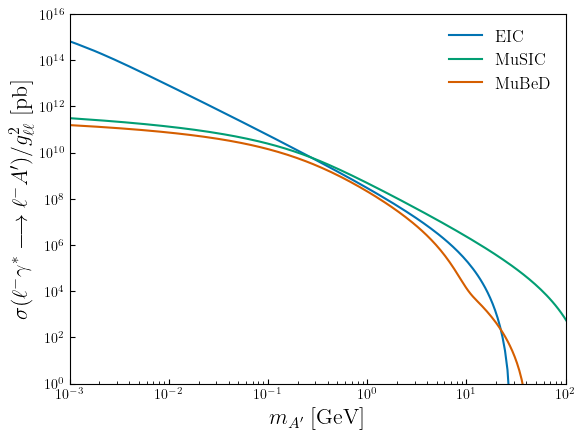

In [6]:
for experiment, mass in plot_masses.items():
    plt.plot(mass, cross_sections[experiment],
             color = color_dict[experiment],
             label = TeX_dict[experiment])

# Make legend
plt.legend(frameon = False, fontsize = 12)

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in')

# x-axis
plt.xscale('log')
plt.xlim(1e-3, 1e2)
plt.xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.yscale('log')
plt.ylim(1e0, 1e16)
plt.ylabel('$\\sigma(\\ell^- \\gamma^* \\longrightarrow \\ell^- A^\\prime)/g_{\\ell\\ell}^2~[{\\rm pb}]$', fontsize = 16)

We see that each of these experiments has a similar raw production cross-section. MuSIC does slightly worse than the EIC at lower masses; this is somewhat counterintuitive, but I think it makes sense. One of the most important factors for determining the size of the cross-section is the size of the minimum photon transfer for which the process is allowed. In particular, the cross-section goes as the inverse square of the photon-transfer, so smaller minimum photon-transfers yield larger cross-sections. Ignoring dependence on the final-state kinematics, the minimum photon-transfer is given by
$$
t_{\rm min.} = \frac{[(m_\ell + m_{A'})^2-m_\ell^2]^2}{4 E^2}
$$
where $E$ is the energy of the initial-state lepton in the ion frame. For the EIC, $m_\ell = m_e\approx 5.11\times 10^{-4}~{\rm GeV}$ and $E \approx 4~{\rm TeV}$, whereas for MuSIC, $m_\ell = m_\mu\approx 0.106~{\rm GeV}$ and $E \approx 20~{\rm TeV}$. The region where the EIC outproduces MuSIC corresponds to the region where $m_e \ll m_{A'} \ll m_\mu$. In this region, we have
$$
t_{\rm min.}^{\rm EIC} \approx \frac{m_{A'}^4}{4 E_{\rm EIC}^2} \approx 150 \left(\frac{m_{A'}}{10~{\rm MeV}}\right)^4~{\rm eV}^2
$$
and
$$
t_{\rm min.}^{\rm MuSIC} \approx \frac{4 m_\mu^2 m_{A'}^2}{4 E_{\rm MuSIC}^2} \approx 3000\left(\frac{m_{A'}}{10~{\rm MeV}}\right)^2~{\rm eV}^2.
$$
Taking the ratio, we find
$$
    \frac{t_{\rm min.}^{\rm MuSIC}}{t_{\rm min.}^{\rm EIC}} \approx 20\left(\frac{10~{\rm MeV}}{m_{A'}}\right)^2
$$
So from this analysis, the photon-transfer from MuSIC only becomes smaller than that at the EIC for $m_{A'}\gtrsim 50~{\rm MeV}$. In reality, it seems this happens closer to $m_{A'} \sim 300~{\rm MeV}$, but we have used the simplifying approximation that $m_{A'} \ll m_\mu$ which is no longer the case for $m_{A'}\sim 50~{\rm MeV}$.

## Production with kernel

In reality, the cross-sections will depend greatly on the geometry of the detector. Here, we will assume a simple kernel which takes in a minimum and maximum pseudo-rapidity according to the geometry of the detector. For the EIC, we take $|\eta| < 3.5$, and for MuSIC, we take $|\eta| < 6.0$. The larger pseudo-rapidity at MuSIC is required for it to be competitive, given how forward-produced the particles are. At MuBeD, we assume $\eta > 2$, because the particles must be somewhat forward produced to be detected. This has a negligible effect on the production cross-section given that the vast majority of particles are produced in the forward direction.

To handle the pseudo-rapidity requirement, we write a simple kernel which computes the pseudo-rapidity $\eta$ in the lab frame from the pseudo-rapidity $\eta$ and log boost $\log{\gamma}$ in the ion frame (which are the default parameters for computing the differential cross-section).

In [7]:
from lepton_nucleus_collisions.compute.transformations import TRANSFORM

def eta_kernel(eta_min = -np.inf, eta_max = np.inf):
    
    def kernel(experiment, final_state, x, y, x_var = 'log_gamma', y_var = 'eta'):
        
        in_context = {'experiment': experiment,
                      'final_state': final_state,
                      'frame': 'ion'}
        out_context = {'experiment': experiment,
                      'final_state': final_state,
                      'frame': 'lab'}

        _, eta = TRANSFORM(x, y, x_in = x_var, y_in = y_var, in_context = in_context, out_context = out_context, include_jacobian = False)
        
        return (eta > eta_min)*(eta < eta_max)
    
    return kernel

In [8]:
eta_kernels = {EIC: eta_kernel(eta_min = -3.5, eta_max = 3.5),
               MuBeD: eta_kernel(eta_min = 5),
               MuSIC: eta_kernel(eta_min = -6, eta_max = 6)
              }

eta_cross_sections = {}
for experiment, mass in plot_masses.items():
   eta_cross_sections[experiment] = np.array([cross_section(experiment, m,
                                                            kernel = eta_kernels[experiment],
                                                            units = 'pb') for m in mass])

Text(0, 0.5, '$\\sigma(\\ell^- \\gamma^* \\longrightarrow \\ell^- A^\\prime)/g_{\\ell\\ell}^2~[{\\rm pb}]$')

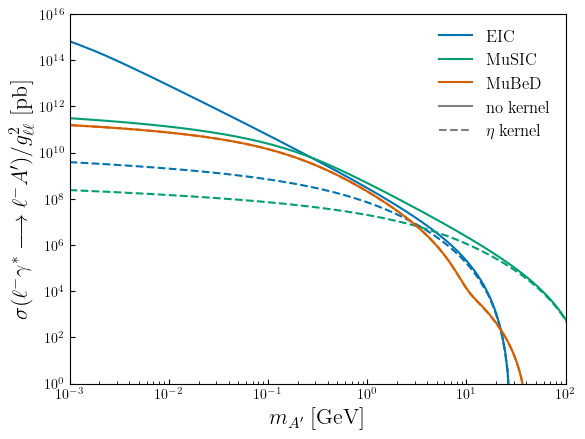

In [9]:
for experiment, mass in plot_masses.items():
    plt.plot(mass, cross_sections[experiment],
             color = color_dict[experiment],
             label = TeX_dict[experiment])

    plt.plot(mass, eta_cross_sections[experiment],
             color = color_dict[experiment],
             linestyle = 'dashed')

# Make legend
plt.plot([1], [1e32], color = 'gray', linestyle = 'solid', label = '$\\textrm{no kernel}$')
plt.plot([1], [1e32], color = 'gray', linestyle = 'dashed', label = '$\\eta~{\\rm kernel}$')
plt.legend(frameon = False, fontsize = 12)

# Format tick parameters
plt.tick_params(which = 'both', direction = 'in')

# x-axis
plt.xscale('log')
plt.xlim(1e-3, 1e2)
plt.xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

# y-axis
plt.yscale('log')
plt.ylim(1e0, 1e16)
plt.ylabel('$\\sigma(\\ell^- \\gamma^* \\longrightarrow \\ell^- A^\\prime)/g_{\\ell\\ell}^2~[{\\rm pb}]$', fontsize = 16)


Including the pseudo-rapidity requirements induces a profound effect on the total cross-sections at MuSIC and the EIC, but only a minor effect on MuBeD, because most of its decay products are forward-produced anyway.

# Hidden Vector Bosons

Now we can apply these production cross-sections to constrain hidden vector bosons at these experiments. To begin, let us get all of the machinery for the dark vector bosons out of the way. (Note: this requires the files **dark_photon_gamma_hadrons.csv** and **B_L_gamma_hadrons.csv** to work. These are the digitized decay widths to hadrons for a dark photon and $U(1)_{B-L}$ gauge boson from Figure 9 of "Serendipity in Dark Photon Searches" (<a href="https://arxiv.org/abs/1801.04847">arXiv:1801.04847</a>.)

## Branching fractions

In [10]:
vector_models = ['EM', 'B-L', 'Lt-Le', 'Lm-Le', 'Lt-Lm', 'electronphilic', 'muonphilic']

def vector_fermion_decay_rate(mA, mf, Q = 1, g = 1, color_factor = 1):
    return np.where(mA < 2*mf, 0, mA/(12*np.pi) * np.sqrt(1 - 4*mf**2/mA**2) * (1 + 2*mf**2/mA**2) * g**2 * Q**2)

def vector_hadron_decay_rate(mA, g = 1, model = 'EM'):
    assert model in vector_models

    if model == 'EM':
        mass, decay_rate = np.loadtxt('thesis_code/displaced_vectors/hadron_decay_rates/dark_photon_width_hadrons.csv',
                                      delimiter = ',',
                                      skiprows = 1,
                                      usecols = [0, 1]).T

        #decay_rate = np.where(mA > mass[-1], decay_rate[-1], g**2 * np.interp(mA, mass, decay_rate))
        #decay_rate = np.where(mA < mass[0], 0, decay_rate)

        decay_rate = mA * np.where(mA < mass[0], 0, g**2 * np.interp(mA, mass, decay_rate))/(12*np.pi)
        
    elif model == 'B-L':

        mass, decay_rate = np.loadtxt('thesis_code/displaced_vectors/hadron_decay_rates/B_L_width_hadrons.csv',
                                      delimiter = ',',
                                      skiprows = 1,
                                      usecols = [0, 1]).T

        #decay_rate = np.where(mA > mass[-1], decay_rate[-1], g**2 * np.interp(mA, mass, decay_rate))
        #decay_rate = np.where(mA < mass[0], 0, decay_rate)

        decay_rate = mA * np.where(mA < mass[0], 0, g**2 * np.interp(mA, mass, decay_rate))/(12*np.pi)
    else:
        decay_rate = np.zeros_like(mA)

    return decay_rate

Q_l = {'EM': [1, 1, 1],
       'B-L': [-1, -1, -1],
       'Lt-Le': [-1, 0, 1],
       'Lm-Le': [-1, 1, 0],
       'Lt-Lm': [0, -1, 1],
       'electronphilic': [1, 0, 0],
       'muonphilic': [0, 1, 0]
       }


Q_nu = {'EM': [0, 0, 0],
        'B-L': [-1, -1, -1],
        'Lt-Le': [-1, 0, 1],
        'Lm-Le': [-1, 1, 0],
        'Lt-Lm': [0, -1, 1],
       'electronphilic': [0, 0, 0],
       'muonphilic': [0, 0, 0]
       }

def partial_width(mA, final_state, g = 1, model = 'EM'):
    assert final_state in ['nu', 'e', 'mu', 'tau', 'had']
    assert model in vector_models

    if final_state == 'nu':
        decay_rate = 0
        for idx in range(3):
            decay_rate += vector_fermion_decay_rate(mA, 0, Q = Q_nu[model][idx],g = g)/2 #divide by 2 because only left-handed
        return decay_rate
        
    if final_state in leptons:
        idx = leptons.index(final_state)
        return vector_fermion_decay_rate(mA, lepton_masses[final_state], Q = Q_l[model][idx], g = g)

    if final_state == 'had':
        return vector_hadron_decay_rate(mA, g = g, model = model)
    
def total_width(mA, g = 1, model = 'EM'):
    final_states = ['nu', 'e', 'mu', 'tau', 'had']
    width = 0
    for final_state in final_states:
        width += partial_width(mA, final_state, g, model)
    return width
        
def branching_fraction(mA, final_state, model = 'EM'):
    if type(final_state) == str:
        assert final_state in ['nu', 'e', 'mu', 'tau', 'had']
        return np.nan_to_num(partial_width(mA, final_state, model = model)/total_width(mA, model = model))
    else:
        return sum([branching_fraction(mA, fs, model = model) for fs in final_state])

As a sanity check, here we plot the branching fractions as a function of mass, referring to Figures 2 and 3 of "Hunting All the Hidden Photons" (<a href="https://arxiv.org/abs/1803.05466">arXiv:1803.05466</a>) for comparison.

### *Dark Photon*

Text(0.5, 1.0, '\\textrm{\\it Dark Photon}')

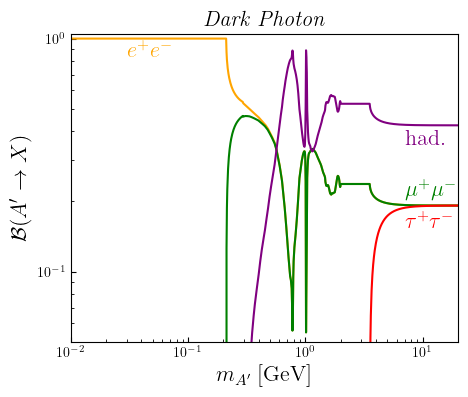

In [11]:
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot()

mA = np.geomspace(1e-2, 2e1, 1000)

final_states = ['nu', 'e', 'mu', 'tau', 'had']
final_state_colors = ['blue', 'orange', 'green', 'red', 'purple']

for color, final_state in zip(final_state_colors, final_states):
    ax.plot(mA, branching_fraction(mA, final_state, 'EM'), color = color)

# Text describing final-states
ax.text(3e-2, 0.84, '$e^+e^-$', fontsize = 16, color = 'orange')
ax.text(7, 0.21, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')
ax.text(7, 0.155, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')
ax.text(7, 0.35, '${\\rm had.}$', fontsize = 16, color = 'purple')

# Format tick parameters
ax.tick_params(which = 'both', direction = 'in')

# x-axis
ax.set_xscale('log')
ax.set_xlim(1e-2, 2e1)
ax.set_xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax.set_yscale('log')
ax.set_ylim(0.05, 1.05)
ax.set_ylabel('${\\cal B}(A^\\prime \\rightarrow X)$', fontsize = 16)

# Title
ax.set_title('\\textrm{\\it Dark Photon}', fontsize = 16)

### $B-L$

Text(0.5, 1.0, '$B-L$')

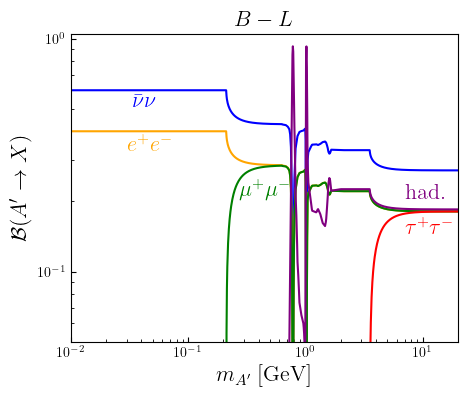

In [12]:
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot()

mA = np.geomspace(1e-2, 2e1, 1000)

final_states = ['nu', 'e', 'mu', 'tau', 'had']
final_state_colors = ['blue', 'orange', 'green', 'red', 'purple']

for color, final_state in zip(final_state_colors, final_states):
    ax.plot(mA, branching_fraction(mA, final_state, 'B-L'), color = color)  

# Text describing final-states
ax.text(3.4e-2, 0.51, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
ax.text(3e-2, 0.33, '$e^+e^-$', fontsize = 16, color = 'orange')
ax.text(2.7e-1, 0.21, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')
ax.text(7, 0.145, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')
ax.text(7, 0.205, '${\\rm had.}$', fontsize = 16, color = 'purple')

# Format tick parameters
ax.tick_params(which = 'both', direction = 'in')

# x-axis
ax.set_xscale('log')
ax.set_xlim(1e-2, 2e1)
ax.set_xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

# y-axis
ax.set_yscale('log')
ax.set_ylim(0.05, 1.05)
ax.set_ylabel('${\\cal B}(A^\\prime \\rightarrow X)$', fontsize = 16)

# Title
ax.set_title('$B-L$', fontsize = 16)

This is not perfect (the rate to hadrons is slightly undercomputed at heavy masses), but it is good enough for our purposes. 

### $L_i - L_j$

Text(6, 0.27, '$\\tau^+\\tau^-$')

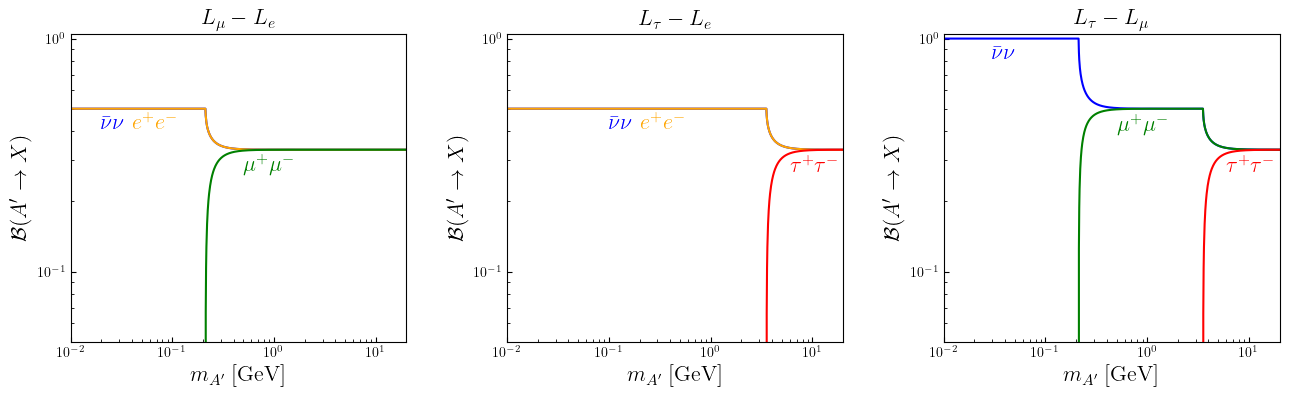

In [13]:
wspace = 0.3
fig = plt.figure(figsize = (3*5 + 2*wspace, 4))
gs = GridSpec(1, 3, wspace = wspace)

mA = np.geomspace(1e-2, 2e1, 1000)

final_states = ['nu', 'e', 'mu', 'tau', 'had']
final_state_colors = ['blue', 'orange', 'green', 'red', 'purple']

axes = [fig.add_subplot(gs[i]) for i in range(3)]
models = ['Lm-Le', 'Lt-Le', 'Lt-Lm']
titles = ['$L_\\mu - L_e$', '$L_\\tau - L_e$', '$L_\\tau - L_\\mu$']
for ax, model, title in zip(axes, models, titles):
    for color, final_state in zip(final_state_colors, final_states):
        ax.plot(mA, branching_fraction(mA, final_state, model), color = color)

    # Format tick parameters
    ax.tick_params(which = 'both', direction = 'in')

    #x-axis
    ax.set_xlim(1e-2, 2e1)
    ax.set_xscale('log')
    ax.set_xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)
    
    #y-axis
    ax.set_yscale('log')  
    ax.set_ylim(0.05, 1.05)
    ax.set_ylabel('${\\cal B}(A^\\prime \\rightarrow X)$', fontsize = 16)

    # Title
    ax.set_title(title, fontsize = 16)

# Text describing final-states
axes[0].text(2e-2, 0.41, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
axes[0].text(4e-2, 0.41, '$e^+e^-$', fontsize = 16, color = 'orange')
axes[0].text(5e-1, 0.27, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')

axes[1].text(1e-1, 0.41, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
axes[1].text(2e-1, 0.41, '$e^+e^-$', fontsize = 16, color = 'orange')
axes[1].text(6, 0.27, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')

axes[2].text(3e-2, 0.82, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
axes[2].text(5e-1, 0.4, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')
axes[2].text(6, 0.27, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')

### All Together

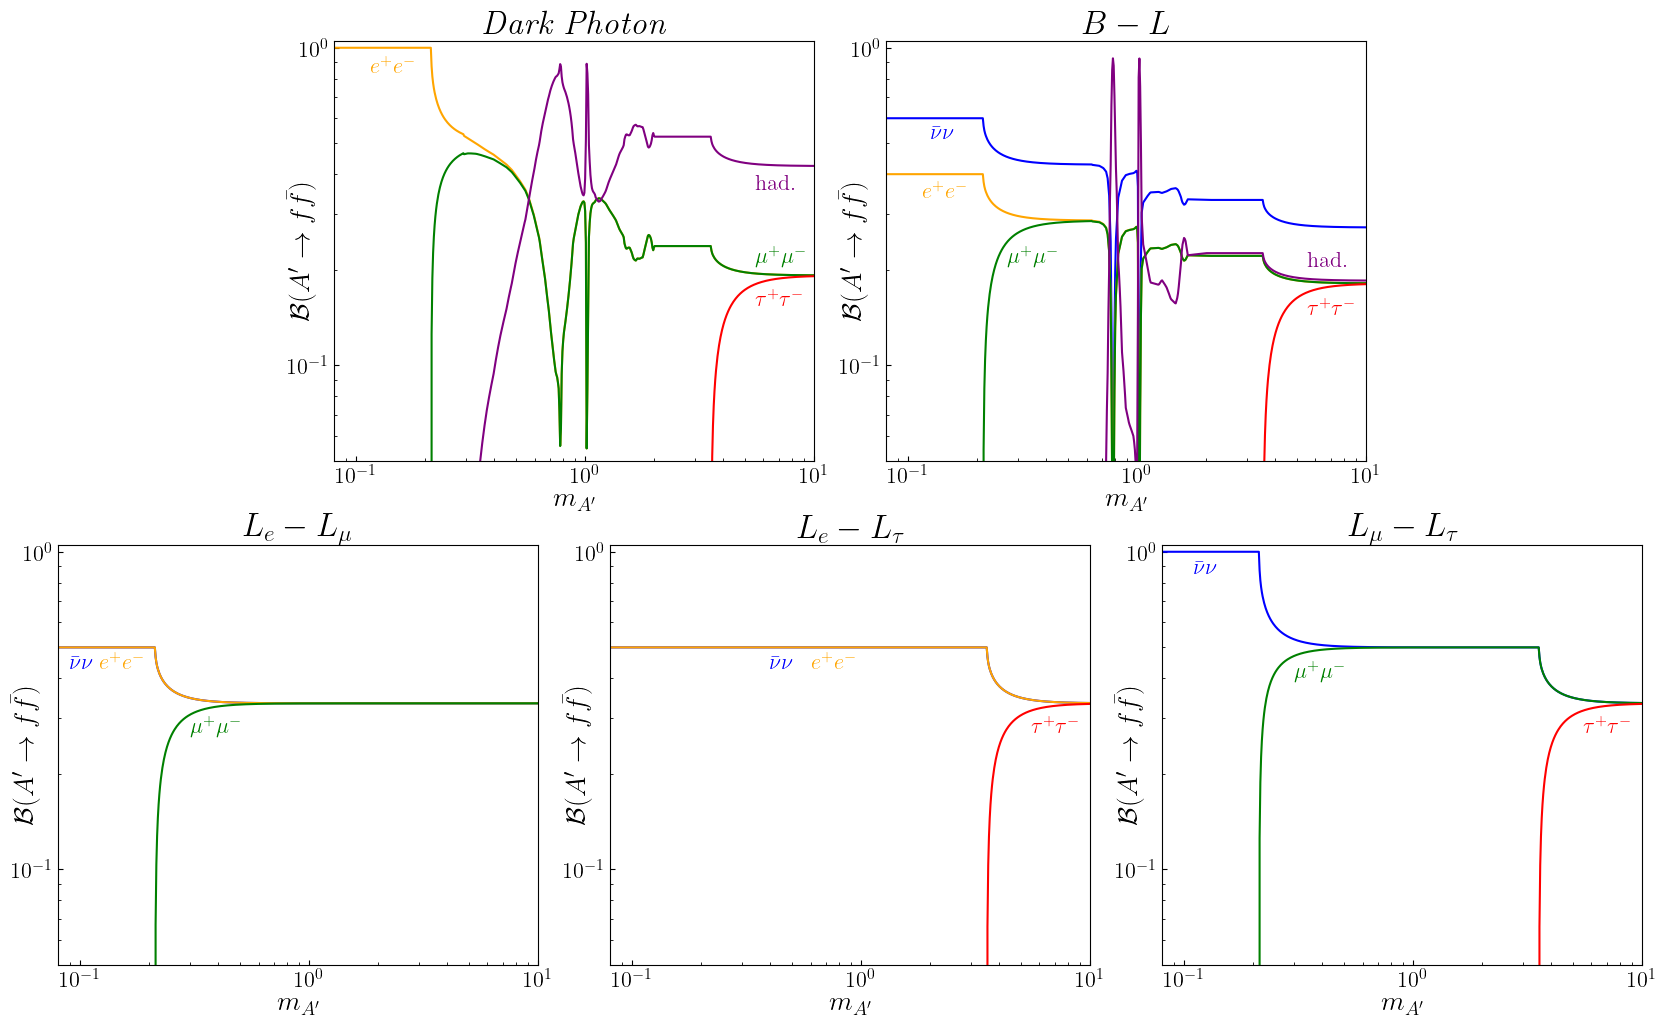

In [14]:
fig = plt.figure(figsize=(24, 12))

# Set consistent panel width, height, and spacing
panel_width = 0.2
panel_height = 0.35
hspace = 0.025
wspace = 0.03

# --- Top row: 2 panels, centered horizontally ---
# Total width of top row = 2 panels + 1 spacing
total_top_width = 2 * panel_width + wspace
start_x_top = 0.5 - total_top_width / 2

ax1 = fig.add_axes([start_x_top,               0.52, panel_width, panel_height])
ax2 = fig.add_axes([start_x_top + panel_width + wspace, 0.52, panel_width, panel_height])

# --- Bottom row: 3 panels, centered horizontally ---
# Total width of bottom row = 3 panels + 2 spacings
total_bottom_width = 3 * panel_width + 2 * wspace
start_x_bottom = 0.5 - total_bottom_width / 2

ax3 = fig.add_axes([start_x_bottom,                    0.1, panel_width, panel_height])
ax4 = fig.add_axes([start_x_bottom + panel_width + wspace,     0.1, panel_width, panel_height])
ax5 = fig.add_axes([start_x_bottom + 2 * (panel_width + wspace), 0.1, panel_width, panel_height])

models = ['EM', 'B-L', 'Lm-Le', 'Lt-Le', 'Lt-Lm']
models_TeX = ['{\\rm EM}', 'B-L', 'L_e - L_\\mu', 'L_e - L_\\tau', 'L_\\mu - L_\\tau']
# Label each panel for clarity
for i, (model, ax) in enumerate(zip(models, [ax1, ax2, ax3, ax4, ax5])):
    for color, final_state in zip(final_state_colors, final_states):
        ax.plot(mA, branching_fraction(mA, final_state, model), color = color)

    # Format tick parameters
    ax.tick_params(which = 'both', direction = 'in')
    
    #x-axis
    ax.set_xlim(0.08, 10)
    ax.set_xscale('log')
    ax.set_xticks([1e-1, 1e0, 1e1], ['$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize = 16)
    ax.set_xlabel('$m_{A^\\prime}$', fontsize = 20, labelpad = 0)

    #y-axis
    ax.set_ylim(0.05, 1.05)
    ax.set_yscale('log')
    ax.set_yticks([1e-1, 1e0], ['$10^{-1}$', '$10^{0}$'], fontsize = 16)
    ax.set_ylabel('${\\cal B}(A^\\prime\\rightarrow f\\bar{f})$', fontsize = 20, labelpad = -20)

    # Title
    if i == 0:
        ax.set_title('$\\it Dark\\ Photon$', fontsize = 24)
    else:
        ax.set_title(f'${models_TeX[i]}$', fontsize = 24)

# Text describing final-states

ax1.text(1.15e-1, 0.84, '$e^+e^-$', fontsize = 16, color = 'orange')
ax1.text(5.5, 0.21, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')
ax1.text(5.5, 0.155, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')
ax1.text(5.5, 0.36, '${\\rm had.}$', fontsize = 16, color = 'purple')

ax2.text(1.25e-1, 0.52, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
ax2.text(1.15e-1, 0.34, '$e^+e^-$', fontsize = 16, color = 'orange')
ax2.text(2.7e-1, 0.21, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')
ax2.text(5.5, 0.145, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')
ax2.text(5.5, 0.205, '${\\rm had.}$', fontsize = 16, color = 'purple')

ax3.text(0.9e-1, 0.43, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
ax3.text(1.2e-1, 0.43, '$e^+e^-$', fontsize = 16, color = 'orange')
ax3.text(3e-1, 0.27, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')

ax4.text(0.4, 0.43, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
ax4.text(0.6, 0.43, '$e^+e^-$', fontsize = 16, color = 'orange')
ax4.text(5.5, 0.27, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')

ax5.text(1.1e-1, 0.86, '$\\bar{\\nu}\\nu$', fontsize = 16, color = 'blue')
ax5.text(3e-1, 0.4, '$\\mu^+\\mu^-$', fontsize = 16, color = 'green')
ax5.text(5.5, 0.27, '$\\tau^+\\tau^-$', fontsize = 16, color = 'red')

# Save figure
plt.savefig('figures/chapter6/gauge_boson_branching_fractions.pdf', format = 'pdf', bbox_inches = 'tight')

## Digitized Limits and Projections

First, we write helper functions to load in the limits:

In [15]:
def load_limits(model):
    folder_name = f'thesis_code/displaced_vectors/existing_limits_and_projections/{model}'
    lim = {}
    df = pd.read_csv(folder_name + '/lim.csv')

    for i in range(0, len(df.columns), 2):
        key_x = df.columns[i]
        key_y = df.columns[i+1]

        key = key_x[:-2]

        x = df[key_x].dropna().values
        y = df[key_y].dropna().values

        lim[key] = np.stack((x,y), axis = 0)

    return lim

def load_projections(model):
    folder_name = f'thesis_code/displaced_vectors/existing_limits_and_projections/{model}'
    proj = {}
    df = pd.read_csv(folder_name + '/proj.csv')

    for i in range(0, len(df.columns), 2):
        key_x = df.columns[i]
        key_y = df.columns[i+1]

        key = key_x[:-2]

        x = df[key_x].dropna().values
        y = df[key_y].dropna().values

        proj[key] = np.stack((x,y), axis = 0)

    return proj

Then, we write helper functions to plot the limits and projections. Note that we only have projections for $EM$, $B-L$, $L_\mu - L_e$, and $L_\tau - L_e$. In particular, we do not plot projections for the projected limits from muon collider experiments, so we have no need for including $L_\tau - L_\mu$ projections, since the EIC is not sensitive to this model.

In [16]:
def plot_limits(model = 'EM', ax = None):

    if not ax:
        ax = plt.gca()
    
    limits = load_limits(model)
    for limit in limits.values():
        ax.fill_between(*limit, facecolor = 'grey', alpha = 0.5)
        ax.plot(*limit, color = 'black', linewidth = 1)

model_proj_colors = {'EM': {'Belle_II': colors[3],
                            'STAR': colors[2],
                            'LHCbD': colors[4],
                            'LHCb_mumu_1': colors[4],
                            'LHCb_mumu_2': colors[4],
                            'HPS': colors[8]},
                     'B-L': {'Belle_II': colors[3],
                             'DUNE': colors[1]},
                     'Lm-Le': {'Belle_II': colors[3],
                             'DUNE': colors[1]},
                     'Lt-Le': {'Belle_II': colors[3],
                             'DUNE': colors[1]}
                    }

def plot_projections(model = 'EM', ax = None):

    if not ax:
        ax = plt.gca()
        
    projections = load_projections(model)

    for name, projection in projections.items():
        if name == 'DUNE':
            ax.plot(*projection, color = model_proj_colors[model][name], linestyle = 'dotted')
        else:
            ax.plot(*projection, color = model_proj_colors[model][name], linestyle = 'dashed')

### EM

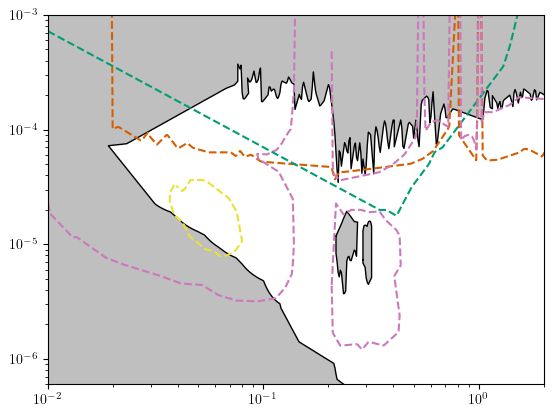

In [17]:
plot_limits('EM')
plot_projections('EM')

plt.xlim(1e-2, 2e0)
plt.xscale('log')

plt.ylim(6e-7, 1e-3)
plt.yscale('log')

### $B-L$

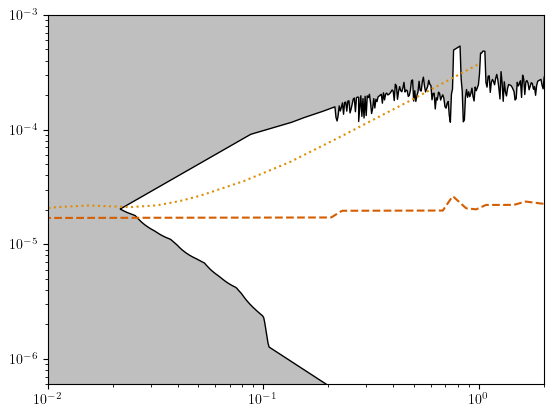

In [18]:
plot_limits('B-L')
plot_projections('B-L')

plt.xlim(1e-2, 2e0)
plt.xscale('log')

plt.ylim(6e-7, 1e-3)
plt.yscale('log')

### $L_\mu - L_e$

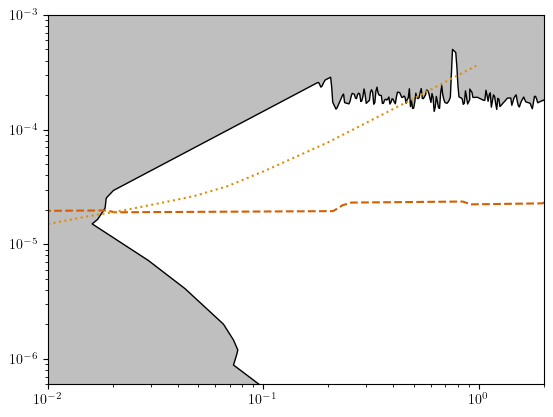

In [19]:
plot_limits('Lm-Le')
plot_projections('Lm-Le')

plt.xlim(1e-2, 2e0)
plt.xscale('log')

plt.ylim(6e-7, 1e-3)
plt.yscale('log')

### $L_\tau - L_e$

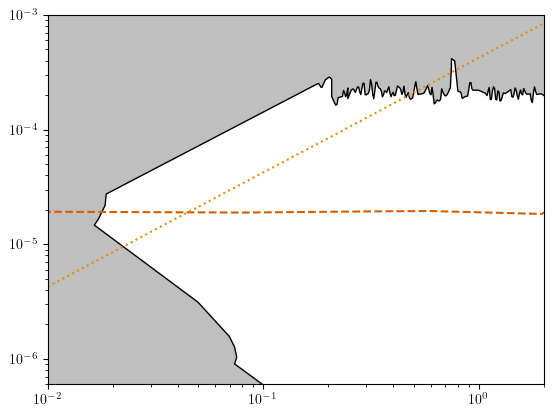

In [20]:
plot_limits('Lt-Le')
plot_projections('Lt-Le')

plt.xlim(1e-2, 2e0)
plt.xscale('log')

plt.ylim(6e-7, 1e-3)
plt.yscale('log')

### $L_\tau - L_\mu$

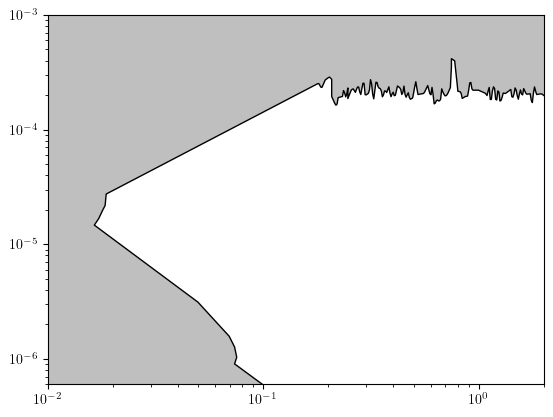

In [21]:
plot_limits('Lt-Lm')

plt.xlim(1e-2, 2e0)
plt.xscale('log')

plt.ylim(6e-7, 1e-3)
plt.yscale('log')

## Calculating Exclusion Limits

### Classical Statistical Analysis of Small Signals

We are now equipped to calculate exclusion limits for the dark boson - lepton coupling at the EIC and MuBeD. First, w4 import a custom function to compute the Poisson confidence interval according to "A Unified Approach to the Classical Statistical Analysis of Small Signals" by Feldman and Cousins (<a href=https://arxiv.org/abs/physics/9711021>arXiv:9711021</a>).

In [22]:
from phys.utils import poisson_confidence_interval

We can compare to the paper by trying to print some of the Tables in the Appendix. Here we print Table II (68.27% C.L. intervals for the Poisson signal mean $\mu$ with observed events $n_0$ ranging from $0$ to $10$ and mean background $b$ ranging from $0$ to $5$). (This takes some time...)

In [23]:
n_observed = np.linspace(0, 20, 21)
background = np.linspace(0, 5, 11)

CL = 0.6827
CL_intervals = [[poisson_confidence_interval(CL, n0, b) for b in background] for n0 in n_observed]

In [24]:
# Print headers
print('n0/b| ' + ''.join([f'{b:<12}' for b in background]))
print("-" * 140)

# Print rows
for n0, row in zip(n_observed, CL_intervals):
    row_string = f'{n0:<4}| '
    
    for interval in row:
        n_min, n_max = interval
        formatted_interval = f'{n_min:.2f},{n_max:.2f}'
        row_string += f'{formatted_interval:<12}'
    
    print(row_string)

n0/b| 0.0         0.5         1.0         1.5         2.0         2.5         3.0         3.5         4.0         4.5         5.0         
--------------------------------------------------------------------------------------------------------------------------------------------
0.0 | 0.00,1.29   0.00,0.80   0.00,0.54   0.00,0.32   0.00,0.15   0.00,0.25   0.00,0.12   0.00,0.20   0.00,0.09   0.00,0.17   0.00,0.08   
1.0 | 0.37,2.75   0.00,2.25   0.00,1.75   0.00,1.32   0.00,0.97   0.00,0.68   0.00,0.44   0.00,0.26   0.00,0.36   0.00,0.21   0.00,0.09   
2.0 | 0.74,4.25   0.44,3.75   0.15,3.25   0.00,2.75   0.00,2.25   0.00,1.79   0.00,1.41   0.00,1.09   0.00,0.81   0.00,0.57   0.00,0.37   
3.0 | 1.10,5.30   0.80,4.80   0.54,4.30   0.32,3.80   0.00,3.30   0.00,2.80   0.00,2.30   0.00,1.84   0.00,1.45   0.00,1.11   0.00,0.82   
4.0 | 2.33,6.78   1.84,6.28   1.33,5.77   0.91,5.28   0.44,4.78   0.25,4.28   0.00,3.78   0.00,3.27   0.00,2.78   0.00,2.31   0.00,1.90   
5.0 | 2.75,7.81   2.25,7.

Note that the upper-right triangle of the table disagrees with the paper's table for $b > n_0 + 1$.

Now we print Table VI (95% C.L. intervals for the Poisson signal mean $\mu$ with observed events $n_0$ ranging from $0$ to $10$ and mean background $b$ ranging from $0$ to $5$).

In [25]:
n_observed = np.linspace(0, 20, 21)
background = np.linspace(0, 5, 11)

CL = 0.95
CL_intervals = [[poisson_confidence_interval(CL, n0, b) for b in background] for n0 in n_observed]

In [26]:
# Print headers
print('n0/b| ' + ''.join([f'{b:<12}' for b in background]))
print("-" * 140)

# Print rows
for n0, row in zip(n_observed, CL_intervals):
    row_string = f'{n0:<4}| '
    
    for interval in row:
        n_min, n_max = interval
        formatted_interval = f'{n_min:.2f},{n_max:.2f}'
        row_string += f'{formatted_interval:<12}'
    
    print(row_string)

n0/b| 0.0         0.5         1.0         1.5         2.0         2.5         3.0         3.5         4.0         4.5         5.0         
--------------------------------------------------------------------------------------------------------------------------------------------
0.0 | 0.00,3.09   0.00,2.63   0.00,2.34   0.00,2.05   0.00,1.78   0.00,1.52   0.00,1.62   0.00,1.38   0.00,1.49   0.00,1.27   0.00,1.38   
1.0 | 0.05,5.14   0.00,4.64   0.00,4.14   0.00,3.69   0.00,3.30   0.00,2.95   0.00,2.63   0.00,2.33   0.00,2.04   0.00,1.78   0.00,1.87   
2.0 | 0.35,6.72   0.00,6.22   0.00,5.72   0.00,5.22   0.00,4.72   0.00,4.26   0.00,3.84   0.00,3.46   0.00,3.11   0.00,2.78   0.00,2.47   
3.0 | 0.82,8.25   0.32,7.75   0.00,7.25   0.00,6.75   0.00,6.25   0.00,5.75   0.00,5.25   0.00,4.78   0.00,4.35   0.00,3.95   0.00,3.58   
4.0 | 1.37,9.76   0.87,9.26   0.37,8.76   0.00,8.26   0.00,7.76   0.00,7.26   0.00,6.76   0.00,6.26   0.00,5.76   0.00,5.28   0.00,4.84   
5.0 | 1.84,11.26  1.47,10

Once again, there is only disagreement for $b > n_0 + 1$.

### Limits on $g$ from Displaced Signal

Now, we actually calculate the exclusion limits. To do so, we assume that the total cross-section is given by
$$
        \sigma = \int{d\theta_k dE_k\,\frac{d\sigma}{dE_k\,d\theta_k}}P_{\rm disp.}\sum_{\rm f.s.}\epsilon_{\rm f.s.}{\cal B}(A'\rightarrow {\rm f.s.})
$$
where the coupling $g$ we are constraining enters through the differential cross-section $d\sigma/dE_k d\theta_k$ ($\sigma \propto Q_\ell^2 g^2$) and in the lifetime of the $A'$ ($\tau_{A'} = \hbar/\Gamma_{A'} \propto 1/g^2$), which appears in the formula for the probability of displacement within the detector:
$$
    P_{\rm disp.} = e^{-d_{\rm min}/\gamma c \tau_{A'}} - e^{-d_{\rm max}/\gamma c \tau_{A'}}.
$$

Here, $d_{\rm min}$ and $d_{\rm max}$ are the minimum and maximum resolvable displacements of the $A'$. For a beam-dump experiment, $d_{\rm min}$ and $d_{\rm max}$ are essentially constants (they depend slightly on the pseudo-rapidity $\theta$, but this only matters if $\theta$ is far from zero. 

In a collider setting, on the other hand, $d_{\rm min}$ can depend strongly on the ability of the detector apparatus to resolve displaced particles from the particle tracks. To determine whether a particle is produced in a displaced decay, one computes the transverse distance-of-closest-approach (${\rm DCA}_{\rm 2D}$) of each reconstructed particle trajectory to the interaction point. If this distance is large enough, it is an indication that the particles did not emanate from the interaction point but from a displaced decay, hence constituting a displaced signal. The resolution of the ${\rm DCA}_{\rm 2D}$ itself depends on the kinematics of the particles, and is worse for larger pseudo-rapidity. According to the specifications of the ePIC detector at the EIC (see <a href = https://arxiv.org/pdf/2209.02580>arXiv:2209.02580</a>), the resolution will be anywhere from $5$-$100~\mu {\rm m}$ for pions depending on their pseudorapidity and transverse momentum. We asume a similar resolution for electrons, and choose ${\rm DCA}_{\rm 2D, res.} = 100~\mu{\rm m}$ regardless of kinematics to be safe.

To relate the ${\rm DCA}_{\rm 2D}$ resolution to the minimum resolvable displacement $d_{\rm min}$, we assume the final-state decay products of the vector boson (for simplicity, consider only electron/positron pairs) are energetic enough that they are mostly unaffected by the magnetic fields inside the tracking region, so that their reconstructed paths are straight-line trajectories. Then, if the electron and positron are produced from the decay of a dark boson with boost $\gamma$, speed $v$, and angle w.r.t. the beam axis $\theta$ at a distance $d$ from the interaction point, we estimate that their corresponding ${\rm DCA}_{\rm 2D}$ will be
$$
    {\rm DCA}_{\rm 2D} = \frac{dv\cos{\theta}}{\gamma}.
$$
Roughly speaking, the $e^+e^-$ decay products from a dark boson with a high boost $\gamma$ will have a smaller opening angle, so their reconstructed trajectory will deviate less from the trajectory of the dark boson, making it difficult to discern whether they are displaced. This equation can be flipped on its head to estimate the minimum resolvable displacement $d_{\rm min}$ to the transverse DCA resolution ${\rm DCA}_{\rm 2D,res.}$. We have
$$
    d_{\rm min} = \frac{\gamma}{v\cos{\theta}}{\rm DCA}_{\rm 2D,res.}
$$
We also assume a mild dependence of $d_{\rm max}$ on the angle of the dark boson w.r.t. beam axis. In particular, since the Silicon trackers are evenly spaced along the beam axis ($z$-axis) with the first Silicon tracker at $z = 25\,{\rm cm}$, we assume the dark photon must decay before this longitudinal distance from the interaction point so that its decay products can be sufficiently tracked. Then, $d_{\rm max} = z_{\rm max}/\cos{\theta} = (25~{\rm cm})/\cos{\theta}$. This can be relaxed if one doesn't require the decay products to pass through each Silicon tracker, but this has little effect on the final results.

With this, the integration kernel is determined to be
$$
    {\cal K}(g; E_k, \theta_k) = P_{\rm disp.}(g; E_k,\theta_k)\sum_{\rm f.s.}\epsilon)_{\rm f.s.}{\cal B}(A'\rightarrow {\rm f.s.})
$$
where the dependence of $P_{\rm disp.}$ on $g$ is in the lifetime $\tau_{A'}$, and on $E_k$ and $\theta_k$ is in the definitions of $d_{\rm min}$ and $d_{\rm max}$ as well as the lab-frame decay length $\gamma c \tau_{A'}$. Noting that $\sigma = Q_\ell^2 g^2 \hat{\sigma}$ , where $\hat{\sigma}$ is the cross-section for $Q_\ell g = 1$, we have
$$
\sigma(g) = Q_\ell^2 g^2 \int{dE_k\,d\theta_k \frac{d\sigma}{dE_k d\theta_k}{\cal K}(g; E_k, \theta_k)}.
$$
We are operating under the assumption that the displaced signal is free of Standard Model background. Then, to place limits on $g$ at the $95$\% CL, we compute the $95\%$ CL interval for the Poisson signal mean number of events, given that there are zero background events and zero observed events: $(0, N_{\rm max})$. The values of $g$ which are excluded are those for which 

$$
    \sigma(g){\cal L} < N_{\rm max}
$$
where ${\cal L}$ is the luminosity at the EIC (we take it to be $100~{\rm fb}^{-1}/A \approx 0.5~{\rm fb}^{-1}$ in Gold mode), and from the table we generated above, $N_{\rm max} = 3.09$.

In [27]:
# The probability that are particle with decay length d_avg decays
# between d_min and d_max.
def displaced_probability(d_avg, d_min, d_max):
    p = (np.exp(-d_min/d_avg) - np.exp(-d_max/d_avg))
    return p * (d_min < d_max)

# Given an experiment, the mass of the dark boson, the luminosity, 
# and a kernel, computes the maximum and minimum values of g .
@lru_cache(maxsize = 10000)
def find_g_range_given_kernel(experiment,
                              mA,
                              luminosity,
                              kernel,
                              g_min = 1e-10,
                              g_max = 1,
                              g_root = None,
                              CL = 0.95
                             ):

    # If the starting bounds are NaN, return NaN
    if np.isnan(g_min) or np.isnan(g_max):
        return np.nan, np.nan

    # Computes the upper bound on the CL confidence interval for 
    # the mean number of signal events given zero observed signal
    # and background events (background free).
    _, N_max = poisson_confidence_interval(CL, 0, 0)

    # We can define a local function N_events which computes the number of expected
    # events given the value of the coupling g. We make sure to cache it so we 
    # aren't doing unecessary calculations.
    @lru_cache(maxsize = 10000)
    def N(g):
        return luminosity * cross_section(experiment, mA, kernel = kernel(g), units = 'fb', g = g)

    # g_min and g_max should lie outside the excluded region, but sometimes 
    # they will lie within it. Rather than cutting the exclusion plot off abruptly,
    # we can find values of g_min and g_max which do lie outside the region. (We 
    # can also potentially use this to find a value g_root which is internal to 
    # the exclusion region if it is not specified).

    if not g_root: 
        if N(g_min) > N_max:
            g_root = g_min
    
        if N(g_max) > N_max:
            g_root = g_max

    while N(g_min) > N_max:
        g_min/=2
        
    while N(g_max) > N_max:
        g_max*=2

    # If g_root isn't specified, find a value of g for which the number of 
    # expected events is above N_max.
    if not g_root:

        # To find a value of g inside the region, we begin with g_min and g_max, which lie
        # outside the region. Then, we generate new candidates by finding the geometric mean
        # of all existing candidates, and we check whether .

        # Given that 7 iterations already generates 2^7 = 128 candidates, we assume there is 
        # no solution if this takes more than 7 tries.
        
        failed_candidates = [g_min, g_max]
        g_root_candidates = failed_candidates
        count = 0
        while all(N(g) < N_max for g in g_root_candidates) and count < 7:

            g_root_candidates =[np.sqrt(gm*gp) for gm, gp in zip(failed_candidates[:-1], failed_candidates[1:])]
            failed_candidates = sorted(failed_candidates + g_root_candidates)

            count += 1
            
        if count == 7:
            return np.nan, np.nan
            
        g_root_candidates = np.array(g_root_candidates)
        g_root = g_root_candidates[np.array([N(g) > N_max for g in g_root_candidates])][0] #just pick the first one...

    g_min_l = g_min
    g_min_h = g_root
    g = g_root
    
    while np.abs(N(g) - N_max) > 0.001: 
        if N(g) > N_max:
            g_min_h, g = g, np.sqrt(g_min_l * g)
        elif N(g) <= N_max:
            g_min_l, g = g, np.sqrt(g_min_h * g)
    g_min = g

    #now, find upper bound
    g_max_h = g_max
    g_max_l = g_root
    g = g_root
    
    while np.abs(N(g) - N_max) > 0.001:
        if N(g) > N_max:
            g_max_l, g = g, np.sqrt(g_max_h*g)
        elif N(g) <= N_max:
            g_max_h, g = g, np.sqrt(g_max_l*g)
    g_max = g

    return g_min, g_max


def find_g_range(experiment,
                 mA,
                 luminosity,
                 g_min = 1e-10,
                 g_max = 1e0,
                 g_root = None,
                 model = 'EM',
                 final_states = ['e', 'mu'],
                 efficiencies = [1.0, 0.86],
                 d_min = 1.0,
                 d_max = 10.0,
                 DCA_analysis = False,
                 B_field_analysis = False,
                 DCA_2D_res = 100e-6,
                 z_max = 0.25,
                 eta_min = -np.inf,
                 eta_max = np.inf,
                 CL = 0.95
                ):

    assert len(efficiencies) == len(final_states)
    
    # Computes an integration kernel (as a function of g) for the cross-section that takes
    # into account the detector geometry and signal efficiencies. If DCA_analysis is True,
    # this estimates the minimum resolvable displaced distance from the 2D DCA resolution
    # of the detector according to the formula d_min = \gamma * (DCA_2D)/(v \cos{\theta}).
    # It also assumes d_max = z_max/cos(theta) where z_max is the spatial extent of the 
    # detector along the beam axis. Otherwise, the minimum and maximum resolvable displacements
    # are just d_min and d_max. 
    
    def displaced_kernel(g):

        def kernel(experiment, final_state, log_gamma, eta, x_var = 'log_gamma', y_var = 'eta'):
            
            # Compute the signal efficiency given the branching fraction of the dark boson in the specified model,
            # and the efficiency of each final-state. 
            signal_efficiency = sum([efficiency * branching_fraction(m, final_state, model = model) for final_state, efficiency in zip(final_states, efficiencies)])

            # The signal efficiency is zero if the particle can't be produced... this information
            # is contained in the charge dict Q_l.
            lepton_idx = leptons.index(experiment.lepton)
            signal_efficiency *= Q_l[model][lepton_idx]**2
            
            # Compute the total decay width of the dark boson, normalized by the coupling squared
            normalized_decay_width = total_width(m, g = 1, model = model)

            # Compute the lab-frame kinematics of the dark boson
            in_context = {'experiment': experiment,
                          'final_state': final_state,
                          'frame': 'ion', 
                          'particle': 'boson'}
            
            out_context = {'experiment': experiment,
                          'final_state': final_state,
                          'frame': 'lab', 
                          'particle': 'boson'}
            
            gamma, eta = TRANSFORM(log_gamma, eta, x_out = 'gamma', y_out = 'eta', in_context = in_context, out_context = out_context, include_jacobian = False)

            # Compute relevant kinematic variables
            v = np.sqrt(1 - 1/gamma**2)
            cos_th = np.tanh(eta) # cos(th) = tanh(eta)
            E_lab = gamma * final_state.boson_mass
            d_avg = gamma*hc_mGeV/(g**2 * normalized_decay_width)

            
            d_min_local = gamma*DCA_2D_res/(v*np.abs(cos_th)) if DCA_analysis else d_min
            d_max_local = z_max/np.abs(cos_th) if DCA_analysis else d_max    

            displaced_prob = displaced_probability(d_avg, d_min_local, d_max_local) 
            
            if B_field_analysis:
                eBc = 0.3 # In units of GeV/m. 
                          # In particular: e = 1e-9 GeV/V, [B] = T = V*s/m^2, and c = 3*10^8 m/s,
                          # so 1 eBc = 1e-9 GeV/V*(B / T) V*s/m^2 * 3*10^8 m/s 
                          # .. 1 eBc = 0.3 (B/T) GeV/m, where we have taken B = 1 T
                
                R = (E_lab/2)/eBc # assume half the energy goes to each final-state lepton
                u = R*v/gamma

                d_max_local = z_max/np.abs(cos_th)
    
                DCA_res = DCA_2D_res / np.abs(cos_th) #roughly...    
    
                # First, for final-states curving towards the vertex
                discriminant = DCA_res**2 - 2*DCA_res*R + u**2
                d_min_local = R*v/gamma + np.where((discriminant > 0)*(discriminant < u**2),
                                                   -np.sqrt(discriminant),
                                                   np.sqrt(discriminant + 4*DCA_res*R))
                displaced_prob = 0.5*displaced_probability(d_avg, d_min_local, d_max_local)

                #Next, for final-states curving away from the vertex
                discriminant = DCA_res**2 - 2*DCA_res*R + u**2
                d_min_local = -u + np.where(discriminant > u**2, 
                                                    np.sqrt(discriminant),
                                                    np.sqrt(discriminant + 4*DCA_res*R))

                displaced_prob += 0.5*displaced_probability(d_avg, d_min_local, d_max_local)

            return signal_efficiency * displaced_prob * (eta > eta_min) * (eta < eta_max)
            
        return kernel

    g_range = []    
    for m in tqdm(mA):

        # There is no point in searching if the signal efficiency is zero
        # or if the charge of the lepton in the beam is zero.
        signal_efficiency = sum([efficiency * branching_fraction(m, final_state, model = model) for final_state, efficiency in zip(final_states, efficiencies)])
        if signal_efficiency == 0 or Q_l[model][leptons.index(experiment.lepton)] == 0:
            g_range.append([np.nan, np.nan])
            continue

        # Make sure they are still somewhat separated
        g_min = g_min/2
        g_max = g_max*2
        
        # Use the values of the last g_min, g_max as the input for the next...
        # This should speed up the search process.
        g_min, g_max = find_g_range_given_kernel(experiment,
                                                 m,
                                                 luminosity,
                                                 displaced_kernel,
                                                 g_min = g_min,
                                                 g_max = g_max,
                                                 g_root = g_root,
                                                 CL = CL)

        g_range.append((g_min, g_max))

    return np.array(g_range).T

Before plotting, we include some useful presets. 

In [28]:
######## EIC presets ########

luminosity_EIC = 100/EIC.A

# In the standard EIC analysis, it is assumed
# that the EIC has a transverse DCA resolution
# of 100 um, a pseudo-rapidity range of |\eta| < 3.5,
# and a maximum longitudinal displacement of 25cm 
# (in line with the first Silicon tracker).

EIC_standard = {'final_states': ['e'],
                'efficiencies': [1],
                'DCA_analysis': True,
                'DCA_2D_res': 100e-6,
                'z_max': 0.25,
                'eta_min': -3.5,
                'eta_max': 3.5
               }

# In the "far backward" EIC analysis, it is assumed
# that this region has a transverse DCA resolution
# of 200 um, a pseudo-rapidity range of |\eta| < 6.0,
# and a maximum longitudinal displacement of 6 m
# (roughly where the B0 spectrometer is on the forward
# side)

EIC_FB = {'final_states': ['e'],
          'efficiencies': [1],
          'DCA_analysis': True,
          'DCA_2D_res': 200e-6,
          'z_max': 5,
          'eta_min': 4,
          'eta_max': 6
         }

######## MuSIC presets ########

luminosity_MuSIC = 400/MuSIC.A

# A standard MuSIC scenario, assuming a pseudo-rapidity reach of 
# |eta| < 6 and a 2D DCA resolution of 100 um.

MuSIC_standard = {'final_states': ['e', 'mu'],
                  'efficiencies': [1, 1],
                  'DCA_analysis': True,
                  'DCA_2D_res': 200e-6,
                  'z_max': 6.0,
                  'eta_min': -6.0,
                  'eta_max': 6.0
                 }

# A "far-backward" MuSIC scenario, assuming a pseudo-rapidity reach of 
# |eta| < 8, a 2D DCA resolution of 1 mm, and a z_max of 30 m (z_max
# would need to be large to capture particles with such high pseudo-
# rapidity).

MuSIC_FB = {'final_states': ['e', 'mu'],
            'efficiencies': [1, 1],
            'DCA_analysis': True,
            'DCA_2D_res': 1e-3,
            'z_max': 30.0,
            'eta_min': 0.0,
            'eta_max': 8.0
           }

######## MuBeD presets ########

# In "The New Physics Case for Beam-Dump Experiments with Accelerated Muon Beams" (arXiv:2310.16110),
# a few different benchmark scenarios for a muon beam dump are considered. We choose
# to examine the scenario E0 = 1.5 TeV, L_tar = 5.0 m, L_sh = 10.0 m, L_dec = 100.0 m,
# and theta_max = 1e-2 (eta_min = 5), and where the number of muons on target is 
# either 10^18 or 10^20.

L_tar = 5 # meters
L_sh = 10 # meters
L_dec = 100 # meters

#Calculate the approximate luminosity of the target
def luminosity_MuBeD(N_MOT = 1e20):
    lead_density = 6.4e24 #GeV/cm^3
    return (lead_density * N_MOT * (100 * L_tar)) / MuBeD.M / cm2_fb

d_min = L_tar + L_sh
d_max = L_tar + L_dec + L_sh
eta_max = 5 
MuBeD_standard = {'final_states': ['e', 'mu'],
                  'efficiencies': [1.0, 1.0],
                  'DCA_analysis': False,
                  'd_min': d_min, #d_min = 1mm
                  'd_max': d_max, #d_max = 30m
                  'eta_min': eta_max
                 }

### EIC projected limits

First, we can plot the EIC results for each of the dark gauge bosons which can be probed there. The plots to compare with are in "Displaced Signals of Hidden Vectors at the Electron-Ion Collider" (<a href=https://arxiv.org/abs/2307.00102>arXiv:2307.00102</a> ). This will take a while to run the first time around, because it is computing the differential cross-sections for the first time as well. Once that's done, it should run much more quickly the second time around.

-----------------EM-----------------


100%|█████████████████████████████████████████| 220/220 [00:16<00:00, 13.43it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:13<00:00, 16.77it/s]


Completed EIC (far-backward)
-----------------B-L-----------------


100%|█████████████████████████████████████████| 220/220 [00:03<00:00, 56.79it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:11<00:00, 19.95it/s]


Completed EIC (far-backward)
-----------------Lm-Le-----------------


100%|█████████████████████████████████████████| 220/220 [00:05<00:00, 43.94it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:10<00:00, 20.47it/s]


Completed EIC (far-backward)
-----------------Lt-Le-----------------


100%|█████████████████████████████████████████| 220/220 [00:09<00:00, 23.13it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:12<00:00, 17.52it/s]


Completed EIC (far-backward)


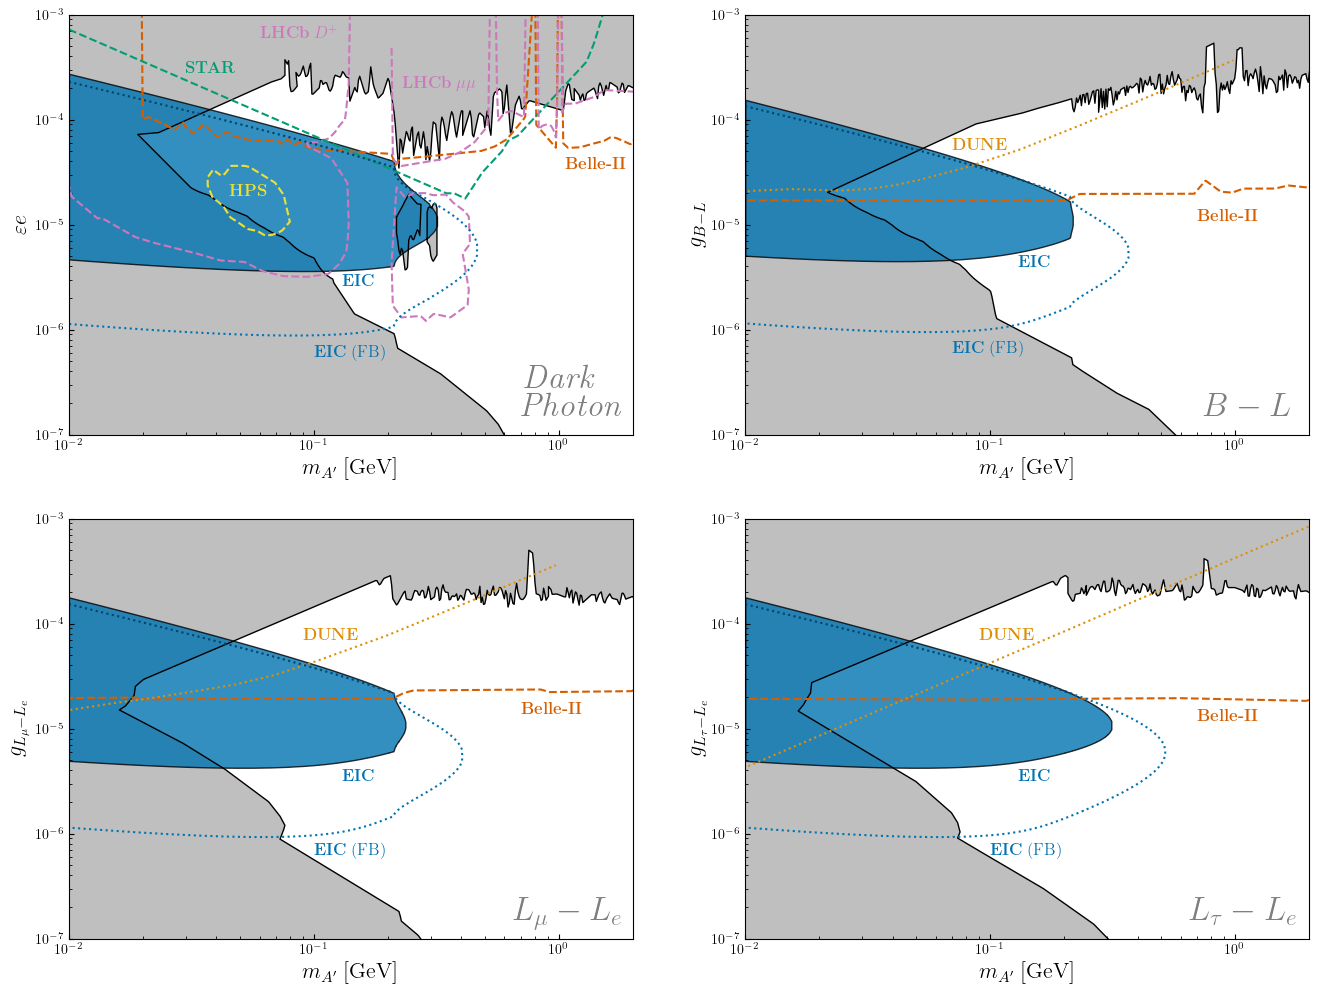

In [29]:
fig = plt.figure(figsize = (16, 12))
gs = GridSpec(2, 2, wspace = 0.2, hspace = 0.2)

axes = [fig.add_subplot(gs[i]) for i in range(4)]

# This set of masses has been chosen to make the excluded region
# as smooth as possible... In particular, a finer set of masses is
# chosen near the right end of the exclusion region. 
plot_masses_EIC = np.geomspace(1e-2, 0.2, 20)
plot_masses_EIC = np.sort(np.append(plot_masses_EIC, np.linspace(0.1, 0.7, 100)))
plot_masses_EIC = np.sort(np.append(plot_masses_EIC, np.linspace(0.2, 0.3, 100)))

models = ['EM', 'B-L', 'Lm-Le', 'Lt-Le']
ylabels = ['$\\varepsilon e$', '$g_{B-L}$', '$g_{L_\\mu - L_e}$', '$g_{L_\\tau - L_e}$']
plot_labels = ['$EM$', '$B-L$', '$L_\\mu - L_e$', '$L_\\tau - L_e$']
for model, ylabel, ax in zip(models, ylabels, axes):

    print(f'-----------------{model}-----------------')

    plot_limits(model = model, ax = ax)
    plot_projections(model = model, ax = ax)
    
    g_min, g_max = find_g_range(EIC, plot_masses_EIC, luminosity_EIC, model = model, **EIC_standard)
    ax.fill_between(plot_masses_EIC, g_min, g_max, color = color_dict[EIC], alpha = 0.8, edgecolor = 'black')

    print('Completed EIC')
    
    g_min_FB, g_max_FB = find_g_range(EIC, plot_masses_EIC, luminosity_EIC, model = model, **EIC_FB)

    non_nan_idcs = ~np.isnan(g_min_FB)
    masses = np.concat((plot_masses_EIC[non_nan_idcs],
                        plot_masses_EIC[non_nan_idcs][::-1]))
    g = np.concat((g_max_FB[non_nan_idcs],
                   g_min_FB[non_nan_idcs][::-1]))
    ax.plot(masses, g, color = color_dict[EIC], linestyle = 'dotted')

    # Add this line to make it easier to see the line when it crosses over the filled-in region
    ax.plot(plot_masses_EIC[g_max_FB < g_max], g_max_FB[g_max_FB < g_max], linestyle = 'dotted', alpha = 0.4, color = 'black')
    
    print('Completed EIC (far-backward)')

    # Format tick parameters
    ax.tick_params(which = 'both', direction = 'in')

    # x-axis
    ax.set_xlim(1e-2, 2e0)
    ax.set_xscale('log')
    ax.set_xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

    # y-axis
    ax.set_ylim(1e-7, 1e-3)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel, fontsize = 16, rotation = 90)


##### PLOT TEXT ####

axes[0].text(0.72, 2.8e-7, '$\\textrm{\\emph{Dark}}$', fontsize = 24, alpha = 0.5)
axes[0].text(0.7, 1.5e-7, '$\\textrm{\\emph{Photon}}$', fontsize = 24, alpha = 0.5)
axes[1].text(0.74, 1.5e-7, '${B-L}$', fontsize = 24, alpha = 0.5)
axes[2].text(0.65, 1.5e-7, '$L_\\mu - L_e$', fontsize = 24, alpha = 0.5)
axes[3].text(0.65, 1.5e-7, '$L_\\tau - L_e$', fontsize = 24, alpha = 0.5)


#EIC

axes[0].text(1.3e-1, 2.6e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[0].text(1e-1, 5.6e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])
axes[1].text(1.3e-1, 4e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[1].text(7e-2, 6e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])
axes[2].text(1.3e-1, 3.2e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[2].text(1e-1, 6.3e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])
axes[3].text(1.3e-1, 3.2e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[3].text(1e-1, 6.3e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])

#Projections EM

axes[0].text(1.06, 3.4e-5, "$\\textrm{\\bf Belle-II}$", fontsize = 12, color = colors[3])
axes[0].text(3e-2, 2.8e-4, "${\\bf STAR}$", fontsize = 12, color = colors[2], alpha = 1)
axes[0].text(6e-2, 6e-4, "${\\bf LHCb}~D^+$", fontsize = 12, color = colors[4], alpha = 1)
axes[0].text(2.3e-1, 2e-4, "${\\bf LHCb}~\\mu\\mu$", fontsize = 12, color = colors[4], alpha = 1)
axes[0].text(4.5e-2, 1.9e-5, "${\\bf HPS}$", fontsize = 12, color = colors[8])

#Projections B-L
axes[1].text(0.7, 1.1e-5, "$\\textrm{\\bf Belle-II}$", fontsize = 12, color = colors[3])
axes[1].text(7e-2, 5.2e-5, "${\\bf DUNE}$", fontsize = 12, color = colors[1])


#Projections Lm - Le
axes[2].text(0.7, 1.4e-5, "$\\textrm{\\bf Belle-II}$", fontsize = 12, color = colors[3])
axes[2].text(9e-2, 7e-5, "${\\bf DUNE}$", fontsize = 12, color = colors[1])

#Projections Lt - Le
axes[3].text(0.7, 1.2e-5, "$\\textrm{\\bf Belle-II}$", fontsize = 12, color = colors[3])
axes[3].text(9e-2, 7e-5, "${\\bf DUNE}$", fontsize = 12, color = colors[1])

plt.savefig('figures/chapter6/dark_bosons_EIC.pdf', format = 'pdf', bbox_inches='tight')

### EIC, MuBeD, and MuSIC

Finally, we can compare the EIC to MuBeD and MuSIC. Since only the EIC is sensitive to $L_\tau - L_e$, we will instead plot $L_\tau - L_\mu$.

-----------------EM-----------------


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.61it/s]


Completed MuBeD (N_MOT = 10^18)


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 18.15it/s]


Completed MuBeD (N_MOT = 10^20)


100%|█████████████████████████████████████████| 220/220 [00:11<00:00, 18.60it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:14<00:00, 15.65it/s]


Completed EIC (far backward)


100%|█████████████████████████████████████████| 220/220 [00:10<00:00, 20.75it/s]


Completed MuSIC


100%|█████████████████████████████████████████| 220/220 [00:16<00:00, 13.26it/s]


Completed MuSIC (far backward)
-----------------B-L-----------------


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 37.20it/s]


Completed MuBeD (N_MOT = 10^18)


100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 24.04it/s]


Completed MuBeD (N_MOT = 10^20)


100%|█████████████████████████████████████████| 220/220 [00:04<00:00, 54.13it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:11<00:00, 19.22it/s]


Completed EIC (far backward)


100%|████████████████████████████████████████| 220/220 [00:01<00:00, 175.55it/s]


Completed MuSIC


100%|█████████████████████████████████████████| 220/220 [00:10<00:00, 20.49it/s]


Completed MuSIC (far backward)
-----------------Lm-Le-----------------


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 38.34it/s]


Completed MuBeD (N_MOT = 10^18)


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 21.89it/s]


Completed MuBeD (N_MOT = 10^20)


100%|█████████████████████████████████████████| 220/220 [00:05<00:00, 41.41it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:11<00:00, 19.58it/s]


Completed EIC (far backward)


100%|████████████████████████████████████████| 220/220 [00:01<00:00, 131.18it/s]


Completed MuSIC


100%|█████████████████████████████████████████| 220/220 [00:10<00:00, 20.51it/s]


Completed MuSIC (far backward)
-----------------Lt-Lm-----------------


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 56.38it/s]


Completed MuBeD (N_MOT = 10^18)


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.31it/s]


Completed MuBeD (N_MOT = 10^20)


100%|██████████████████████████████████████| 220/220 [00:00<00:00, 33924.52it/s]


Completed EIC


100%|██████████████████████████████████████| 220/220 [00:00<00:00, 35126.84it/s]


Completed EIC (far backward)


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1412.47it/s]


Completed MuSIC


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1361.69it/s]


Completed MuSIC (far backward)


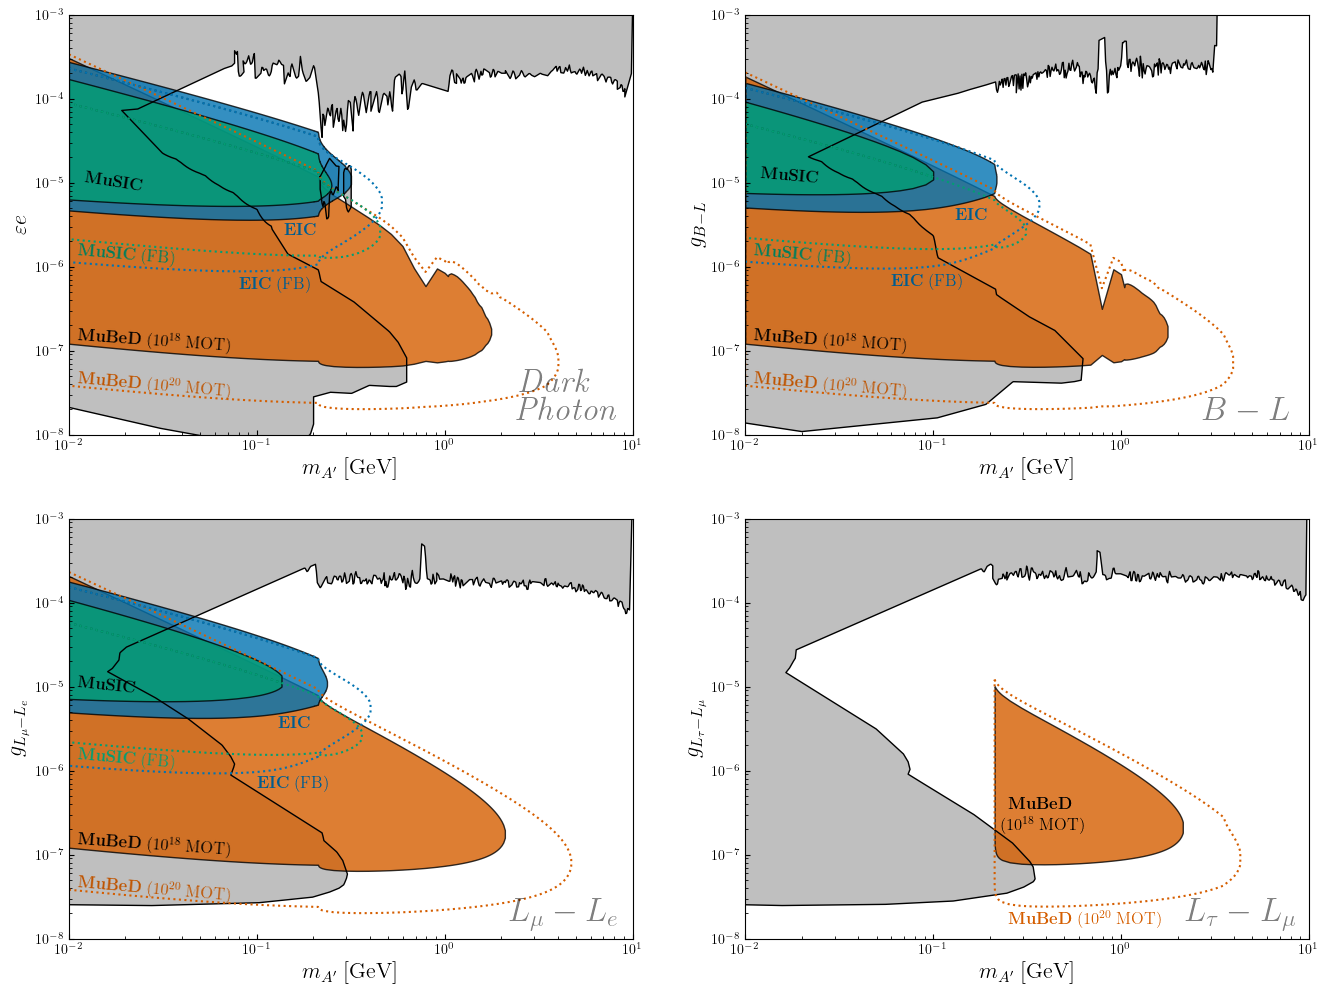

In [30]:
fig = plt.figure(figsize = (16, 12))
gs = GridSpec(2, 2, wspace = 0.2, hspace = 0.2)

axes = [fig.add_subplot(gs[i]) for i in range(4)]

# Once again, chosen to make the curves look as smooth
# as possible.
plot_masses_MuBeD = np.geomspace(1e-2, 10, 50)
plot_masses_MuBeD = np.sort(np.append(plot_masses_MuBeD, np.linspace(1.0, 5.0, 100)))
plot_masses_MuBeD = np.sort(np.append(plot_masses_MuBeD, np.linspace(1.9*mm, 2.2*mm, 50))) #more points near mass of muon

plot_masses_MuSIC = np.geomspace(1e-2, 0.2, 20)
plot_masses_MuSIC = np.sort(np.append(plot_masses_MuSIC, np.linspace(0.1, 0.6, 100)))
plot_masses_MuSIC = np.sort(np.append(plot_masses_MuSIC, np.linspace(0.2, 0.3, 100)))

# Same masses for EIC as before
plot_masses_EIC = np.geomspace(1e-2, 0.2, 20)
plot_masses_EIC = np.sort(np.append(plot_masses_EIC, np.linspace(0.1, 0.6, 100)))
plot_masses_EIC = np.sort(np.append(plot_masses_EIC, np.linspace(0.2, 0.3, 100)))

models = ['EM', 'B-L', 'Lm-Le', 'Lt-Lm']
ylabels = ['$\\varepsilon e$', '$g_{B-L}$', '$g_{L_\\mu - L_e}$', '$g_{L_\\tau - L_\\mu}$']
plot_labels = ['$EM$', '$B-L$', '$L_\\mu - L_e$', '$L_\\tau - L_\\mu$']
for model, ylabel, plot_label, ax in zip(models, ylabels, plot_labels, axes):

    print(f'-----------------{model}-----------------')

    plot_limits(model = model, ax = ax)

    # MuBeD N_MOT = 10^18 limits
    g_min, g_max = find_g_range(MuBeD, plot_masses_MuBeD, luminosity_MuBeD(N_MOT = 1e18), model = model, **MuBeD_standard)
    ax.fill_between(plot_masses_MuBeD, g_min, g_max, color = color_dict[MuBeD], alpha = 0.8, edgecolor = 'black')

    print('Completed MuBeD (N_MOT = 10^18)')

    # MuBeD N_MOT = 10^20 limits
    g_min, g_max = find_g_range(MuBeD, plot_masses_MuBeD, luminosity_MuBeD(N_MOT = 1e20), model = model, **MuBeD_standard)
    
    # To connect the endpoints, sew g_min and g_max together
    non_nan_idcs = ~np.isnan(g_min)
    masses = np.concat((plot_masses_MuBeD[non_nan_idcs],
                        plot_masses_MuBeD[non_nan_idcs][::-1]))

    masses = np.append(masses, masses[0])
    
    g = np.concat((g_max[non_nan_idcs],
                   g_min[non_nan_idcs][::-1]))
    g = np.append(g, g[0])

    ax.plot(masses, g, color = color_dict[MuBeD], linestyle = 'dotted')
    
    print('Completed MuBeD (N_MOT = 10^20)')

    # Standard EIC limits
    g_min, g_max = find_g_range(EIC, plot_masses_EIC, luminosity_EIC, model = model, **EIC_standard)
    ax.fill_between(plot_masses_EIC, g_min, g_max, color = color_dict[EIC], alpha = 0.8, edgecolor = 'black')

    print('Completed EIC')

    # Far-backward EIC limits
    g_min_FB, g_max_FB = find_g_range(EIC, plot_masses_EIC, luminosity_EIC, model = model, **EIC_FB)
    
    # Add this line to make it easier to see the line when it crosses over the filled-in region
    ax.plot(plot_masses_EIC[g_max_FB < g_max], g_max_FB[g_max_FB < g_max], linestyle = 'dotted', alpha = 0.4, color = 'black')

    # To connect the endpoints, sew g_min and g_max together
    non_nan_idcs = ~np.isnan(g_min_FB)
    masses = np.concat((plot_masses_EIC[non_nan_idcs],
                        plot_masses_EIC[non_nan_idcs][::-1]))
    g = np.concat((g_max_FB[non_nan_idcs],
                   g_min_FB[non_nan_idcs][::-1]))
    ax.plot(masses, g, color = color_dict[EIC], linestyle = 'dotted')
    
    print('Completed EIC (far backward)')

    # Standard MuSIC limits
    g_min, g_max = find_g_range(MuSIC, plot_masses_MuSIC, luminosity_MuSIC, model = model, **MuSIC_standard)
    ax.fill_between(plot_masses_MuSIC, g_min, g_max, color = color_dict[MuSIC], alpha = 0.8, edgecolor = 'black')

    print('Completed MuSIC')

    # Far-backward MuSIC limits
    g_min_FB, g_max_FB = find_g_range(MuSIC, plot_masses_MuSIC, luminosity_MuSIC, model = model, **MuSIC_FB)
    
    # Add this line to make it easier to see the line when it crosses over the filled-in region
    ax.plot(plot_masses_MuSIC[g_max_FB < g_max], g_max_FB[g_max_FB < g_max], linestyle = 'dotted', alpha = 0.4, color = 'black')

    # To connect the endpoints, sew g_min and g_max together
    non_nan_idcs = ~np.isnan(g_min_FB)
    masses = np.concat((plot_masses_MuSIC[non_nan_idcs],
                        plot_masses_MuSIC[non_nan_idcs][::-1]))
    g = np.concat((g_max_FB[non_nan_idcs],
                   g_min_FB[non_nan_idcs][::-1]))
    ax.plot(masses, g, color = color_dict[MuSIC], linestyle = 'dotted')
    
    print('Completed MuSIC (far backward)')

    # Format tick parameters
    ax.tick_params(which = 'both', direction = 'in')

    # x-axis
    ax.set_xlim(1e-2, 1e1)
    ax.set_xscale('log')
    ax.set_xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

    # y-axis
    ax.set_ylim(1e-8, 1e-3)
    ax.set_yscale('log')
    ax.set_ylabel(ylabel, fontsize = 16, rotation = 90)

##### PLOT TEXT #####

axes[0].text(2.5, 3.2e-8, '$\\textrm{\\emph{Dark}}$', fontsize = 24, alpha = 0.5)
axes[0].text(2.4, 1.5e-8, '$\\textrm{\\emph{Photon}}$', fontsize = 24, alpha = 0.5)
axes[1].text(2.7, 1.5e-8, '${B-L}$', fontsize = 24, alpha = 0.5)
axes[2].text(2.2, 1.6e-8, '$L_\\mu - L_e$', fontsize = 24, alpha = 0.5)
axes[3].text(2.2, 1.6e-8, '$L_\\tau - L_\\mu$', fontsize = 24, alpha = 0.5)


#EIC
axes[0].text(1.4e-1, 2.4e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[0].text(1.4e-1, 2.4e-6, '${\\bf EIC}$', fontsize = 12, color = 'black', alpha=0.2)
axes[0].text(8e-2, 5.5e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])
axes[0].text(8e-2, 5.5e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = 'black', alpha=0.2)
axes[1].text(1.3e-1, 3.6e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[1].text(1.3e-1, 3.6e-6, '${\\bf EIC}$', fontsize = 12, color = 'black', alpha=0.2)
axes[1].text(6e-2, 6e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])
axes[1].text(6e-2, 6e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = 'black', alpha=0.2)
axes[2].text(1.3e-1, 3.2e-6, '${\\bf EIC}$', fontsize = 12, color = colors[0])
axes[2].text(1.3e-1, 3.2e-6, '${\\bf EIC}$', fontsize = 12, color = 'black', alpha=0.2)
axes[2].text(1e-1, 6.3e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = colors[0])
axes[2].text(1e-1, 6.3e-7, '${\\bf EIC}~(\\textrm{FB})$', fontsize = 12, color = 'black', alpha=0.2)

#MuSIC
axes[0].text(1.2e-2, 8e-6, '${\\bf MuSIC}$', fontsize = 12, color = 'black', rotation = -9)
axes[0].text(1.1e-2, 1.1e-6, '${\\bf MuSIC}~(\\textrm{FB})$', fontsize = 12, color = colors[2], rotation = -5)
axes[0].text(1.1e-2, 1.1e-6, '${\\bf MuSIC}~(\\textrm{FB})$', fontsize = 12, color = 'black', alpha=0.2, rotation = -5)
axes[1].text(1.2e-2, 1.0e-5, '${\\bf MuSIC}$', fontsize = 12, color = 'black', rotation = -5)
axes[1].text(1.1e-2, 1.1e-6, '${\\bf MuSIC}~(\\textrm{FB})$', fontsize = 12, color = colors[2], rotation = -5)
axes[1].text(1.1e-2, 1.1e-6, '${\\bf MuSIC}~(\\textrm{FB})$', fontsize = 12, color = 'black', alpha=0.2, rotation = -5)
axes[2].text(1.1e-2, 8.5e-6, '${\\bf MuSIC}$', fontsize = 12, color = 'black', rotation = -6)
axes[2].text(1.1e-2, 1.1e-6, '${\\bf MuSIC}~(\\textrm{FB})$', fontsize = 12, color = colors[2], rotation = -5)

#MuBeD
axes[0].text(1.1e-2, 1.0e-7, '${\\bf MuBeD}~(10^{18}~{\\rm MOT})$', fontsize = 12, color = 'black', rotation = -4)
axes[0].text(1.1e-2, 2.9e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = colors[3], rotation = -5)
axes[0].text(1.1e-2, 2.9e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = 'black', alpha = 0.1, rotation = -5)
axes[1].text(1.1e-2, 1.0e-7, '${\\bf MuBeD}~(10^{18}~{\\rm MOT})$', fontsize = 12, color = 'black', rotation = -4)
axes[1].text(1.1e-2, 2.9e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = colors[3], rotation = -5)
axes[1].text(1.1e-2, 2.9e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = 'black', alpha = 0.1, rotation = -5)
axes[2].text(1.1e-2, 1.0e-7, '${\\bf MuBeD}~(10^{18}~{\\rm MOT})$', fontsize = 12, color = 'black', rotation = -4)
axes[2].text(1.1e-2, 2.9e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = colors[3], rotation = -5)
axes[2].text(1.1e-2, 2.9e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = 'black', alpha = 0.1, rotation = -5)
axes[3].text(0.25, 3.5e-7, '${\\bf MuBeD}$', fontsize = 12, color = 'black')
axes[3].text(0.23, 2e-7, '$(10^{18}~{\\rm MOT})$', fontsize = 12, color = 'black')
axes[3].text(0.25, 1.5e-8, '${\\bf MuBeD}~(10^{20}~{\\rm MOT})$', fontsize = 12, color = colors[3])

plt.savefig('figures/chapter6/dark_bosons_MuBeD_MuSIC.pdf', format = 'pdf', bbox_inches='tight')

We find good agreement between the dark photon exclusions from the muon beam dump and Fig. 20 (b) of  <a href="https://arxiv.org/abs/2310.16110">arXiv:2310.16110</a>. We also find good agreement between the limits on $g_{L_\tau - L_\mu}$ and the limits on a muonphilic vector in Fig. 16 (c). These should be the same, because the vector boson for $U(1)_{L_\tau - L_\mu}$ only decays to $\mu^+\mu^-$ as long as $m_{A'} < 2m_\tau$.

### Adding a Strong Magnetic Field

Here we investigate the effects on the DCA analysis of a $1~{\rm T}$ transverse magnetic field. While this situation is not realistic, it will nonetheless capture the maximal deviation from the "straight-line trajectory" approximation computed above.

In [31]:

# Here, we make a crude approximation of the 
# effect of a 1 T magnetic field on the DCA
# to see whether it makes a substantive
# difference.

EIC_B_field = {'final_states': ['e'],
               'efficiencies': [1],
               'DCA_analysis': True,
               'B_field_analysis': True,
               'DCA_2D_res': 100e-6,
               'z_max': 0.25,
               'eta_min': -3.5,
               'eta_max': 3.5
              }


MuSIC_B_field = {'final_states': ['e', 'mu'],
                 'efficiencies': [1, 1],
                 'DCA_analysis': True,
                 'B_field_analysis': True,
                 'DCA_2D_res': 200e-6,
                 'z_max': 6.0,
                 'eta_min': -6.0,
                 'eta_max': 6.0
                }

--------------Standard analysis--------------


100%|█████████████████████████████████████████| 220/220 [00:22<00:00,  9.88it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:06<00:00, 32.99it/s]


Completed MuSIC
--------------B-field analysis--------------


100%|█████████████████████████████████████████| 220/220 [00:16<00:00, 13.08it/s]


Completed EIC


100%|█████████████████████████████████████████| 220/220 [00:07<00:00, 30.94it/s]


Completed MuSIC


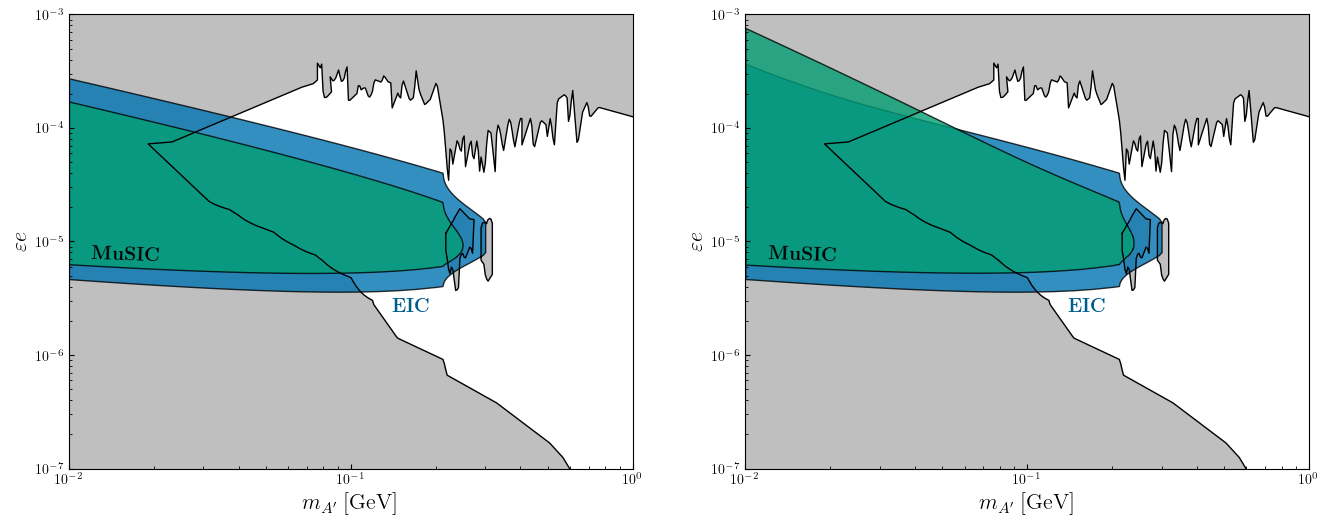

In [32]:
fig = plt.figure(figsize = (16, 5.9))
gs = GridSpec(1, 2, wspace = 0.2)
axes = [fig.add_subplot(gs[i]) for i in range(2)]


plot_masses_MuSIC = np.geomspace(1e-2, 0.2, 20)
plot_masses_MuSIC = np.sort(np.append(plot_masses_MuSIC, np.linspace(0.1, 0.6, 100)))
plot_masses_MuSIC = np.sort(np.append(plot_masses_MuSIC, np.linspace(0.2, 0.3, 100)))

plot_masses_EIC = np.geomspace(1e-2, 0.2, 20)
plot_masses_EIC = np.sort(np.append(plot_masses_EIC, np.linspace(0.2, 0.3, 200)))

model = 'EM'

for i, (EIC_params, MuSIC_params, ax) in enumerate(zip([EIC_standard, EIC_B_field], [MuSIC_standard, MuSIC_B_field], axes)):

    if i == 0:
        print('--------------Standard analysis--------------')
    if i == 1:
        print('--------------B-field analysis--------------')

    plot_limits(model = 'EM', ax = ax)
    
    # Modified EIC limits
    g_min, g_max = find_g_range(EIC, plot_masses_EIC, luminosity_EIC, model = model, **EIC_params)
    ax.fill_between(plot_masses_EIC, g_min, g_max, color = color_dict[EIC], alpha = 0.8, edgecolor = 'black')
    
    print('Completed EIC')
    
    # Modified MuSIC limits
    g_min, g_max = find_g_range(MuSIC, plot_masses_MuSIC, luminosity_MuSIC, model = model, **MuSIC_params)
    ax.fill_between(plot_masses_MuSIC, g_min, g_max, color = color_dict[MuSIC], alpha = 0.8, edgecolor = 'black')

    print('Completed MuSIC')
    
    # Format tick params  
    ax.tick_params(which = 'both', direction = 'in')

    # x-axis
    ax.set_xlim(1e-2, 1e0)
    ax.set_xscale('log')
    ax.set_xlabel('$m_{A^\\prime}~[{\\rm GeV}]$', fontsize = 16)

    # y-axis
    ax.set_ylim(1e-7, 1e-3)
    ax.set_yscale('log')
    ax.set_ylabel('$\\varepsilon e$', fontsize = 16, rotation = 90)

#EIC 

axes[0].text(1.4e-1, 2.4e-6, '${\\bf EIC}$', fontsize = 14, color = colors[0])
axes[0].text(1.4e-1, 2.4e-6, '${\\bf EIC}$', fontsize = 14, color = 'black', alpha=0.2)
axes[1].text(1.4e-1, 2.4e-6, '${\\bf EIC}$', fontsize = 14, color = colors[0])
axes[1].text(1.4e-1, 2.4e-6, '${\\bf EIC}$', fontsize = 14, color = 'black', alpha=0.2)

#MuSIC 
axes[0].text(1.2e-2, 6.8e-6, '${\\bf MuSIC}$', fontsize = 14, color = 'black', rotation = -2)
axes[1].text(1.2e-2, 6.8e-6, '${\\bf MuSIC}$', fontsize = 14, color = 'black', rotation = -2)

plt.savefig('figures/chapter6/dark_bosons_B_field_analysis.pdf', format = 'pdf', bbox_inches='tight')